In [58]:
import os, sklearn, math
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt


tf.random.set_seed(42)

data = '230802_Axial_z2_8Data'
dataname = data+'_Class_'+'01'
filename = 'myData/'+data+'.csv'
SD1 = pd.read_csv(filename)
SD1=SD1.iloc[:,:13]
SensorData1 = SD1

In [59]:
SD1.sample(5)

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Sx07,Force,encoder,z,theta,r
40872,27,32,51,50,43,48,57,64,45.10,0,26,0,7.2
113218,35,35,51,44,50,54,60,58,18.82,0,76,0,3.2
219234,42,37,46,41,51,44,67,51,34.79,0,148,0,4.8
197284,41,36,45,41,44,48,59,59,6.18,0,134,0,0.8
41168,28,33,50,48,40,51,56,64,51.19,0,26,0,8.0


In [60]:
SDreal = SD1

In [61]:
SDreal.describe()

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Sx07,Force,encoder,z,theta,r
count,235079.000000,235079.000000,235079.000000,235079.000000,235079.000000,235079.000000,235079.000000,235079.000000,235079.000000,235079.0,235079.000000,235079.0,235079.000000
mean,37.855602,35.384769,47.421667,43.813399,45.391064,50.105960,60.760553,60.335164,28.366040,0.0,78.786263,0.0,4.397089
std,29.678911,77.255275,58.529797,71.599723,50.843784,71.695767,77.129128,50.722240,28.043329,0.0,46.194791,0.0,2.298731
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-483.760000,0.0,0.000000,0.0,0.800000
25%,36.000000,33.000000,45.000000,41.000000,44.000000,48.000000,59.000000,59.000000,11.960000,0.0,38.000000,0.0,2.400000
50%,38.000000,35.000000,47.000000,43.000000,46.000000,50.000000,60.000000,61.000000,29.310000,0.0,78.000000,0.0,4.000000
75%,40.000000,37.000000,49.000000,46.000000,47.000000,52.000000,62.000000,62.000000,43.440000,0.0,118.000000,0.0,6.400000
max,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000,8191.000000,10001.950000,0.0,158.000000,0.0,8.000000


In [62]:
# SDreal 값이 0보다 작은데 encoder 인 것 제거
SDreal = SDreal[~((SDreal < 0)&(SDreal.columns != "encoder")).any(axis=1)]
#SDreal = SDreal[~((SDreal['z'] % 2 == 0) & (SDreal['z'] % 4 != 0))]

# SDreal 값이 100보다 크거나 0인데, 'theta', 'z', 'Force' 열이 아닌 것 제거
SDreal = SDreal[~(((SDreal >= 80)|(SDreal == 0) ) & 
                 (SDreal.columns != "theta") &
                 (SDreal.columns != "z") &
                 (SDreal.columns != "Force") &
                  (SDreal.columns != "encoder")).any(axis=1)]

# SDreal 값이 8191이거나 8190인 것 제거
SDreal = SDreal[~((SDreal == 8191) | (SDreal == 8190)).any(axis=1)]

# SDreal에서 결측값 제거
SDreal = SDreal[~SDreal.isna().any(axis=1)]

SDreal = SDreal[~((SDreal >= 800) & (SDreal.columns == "Force")).any(axis=1)]
SDreal = SDreal[~((SDreal <= -300) & (SDreal.columns == "Force")).any(axis=1)]


SDreal['contact'] = (SDreal['r'] >= 0.8*2).astype(int)

Zinit = 10
Zend = 150

SDreal = SDreal[SDreal["z"] >= Zinit]
SDreal = SDreal[SDreal["z"] <= Zend]



SDreal["z"] -= Zinit
SDreal["z"] /= 2

SDreal.describe()

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Sx07,Force,encoder,z,theta,r,contact
count,197146.000000,197146.000000,197146.000000,197146.000000,197146.000000,197146.000000,197146.000000,197146.000000,197146.000000,197146.0,197146.000000,197146.0,197146.000000,197146.000000
mean,37.601879,34.617365,47.319372,43.385973,45.281335,49.953517,60.291698,60.524540,30.511125,0.0,35.835569,0.0,4.571589,0.943199
std,2.915937,3.125061,3.193659,3.673693,3.281114,3.512573,2.975097,3.437707,17.076435,0.0,20.431699,0.0,2.210036,0.231462
min,4.000000,3.000000,16.000000,10.000000,3.000000,6.000000,4.000000,5.000000,0.000000,0.0,0.000000,0.0,0.800000,0.000000
25%,36.000000,33.000000,45.000000,41.000000,44.000000,48.000000,59.000000,59.000000,16.682500,0.0,18.000000,0.0,2.400000,1.000000
50%,38.000000,35.000000,47.000000,43.000000,46.000000,50.000000,60.000000,61.000000,31.420000,0.0,36.000000,0.0,4.800000,1.000000
75%,40.000000,37.000000,49.000000,46.000000,47.000000,52.000000,62.000000,63.000000,44.720000,0.0,53.000000,0.0,6.400000,1.000000
max,61.000000,64.000000,68.000000,68.000000,74.000000,75.000000,76.000000,75.000000,68.550000,0.0,70.000000,0.0,8.000000,1.000000


In [63]:
def normalize_dataframe(df, columns):
    for column in columns:
        df[column] = (df[column] - df[column].mean()) / (df[column].max() - df[column].min()) * 2
    return df


#SDreal_normalized = normalize_dataframe(SDreal)
#SDreal_normalized = normalize_dataframe(SDreal, ['r', 'Force', 'z'])
SDreal_normalized = normalize_dataframe(SDreal, ['r', 'Force'])
SDreal = SDreal_normalized
SDreal

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Sx07,Force,encoder,z,theta,r,contact
15159,41,34,46,40,44,53,63,58,-0.827166,0,0.0,0,-0.825441,1
15160,41,34,46,40,47,53,63,58,-0.825999,0,0.0,0,-0.825441,1
15161,41,36,46,43,47,53,63,58,-0.829209,0,0.0,0,-0.825441,1
15162,41,37,45,43,47,52,61,58,-0.828625,0,0.0,0,-0.825441,1
15163,41,37,45,44,47,52,61,58,-0.828333,0,0.0,0,-0.825441,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223380,40,34,44,44,42,44,60,47,0.813680,0,70.0,0,0.952337,1
223381,40,34,44,44,42,44,60,47,0.812805,0,70.0,0,0.952337,1
223382,39,34,44,44,41,45,60,47,0.813972,0,70.0,0,0.952337,1
223383,39,34,44,44,41,45,64,47,0.813972,0,70.0,0,0.952337,1


In [64]:
SDy = SDreal.iloc[:,[13]]
SDy.describe()

,contact
count,197146.000000
mean,0.943199
std,0.231462
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [65]:
X = SDreal.iloc[:,:8]
y = SDreal.iloc[:,[13]]

In [66]:
X

,Sx00,Sx01,Sx02,Sx03,Sx04,Sx05,Sx06,Sx07
15159,41,34,46,40,44,53,63,58
15160,41,34,46,40,47,53,63,58
15161,41,36,46,43,47,53,63,58
15162,41,37,45,43,47,52,61,58
15163,41,37,45,44,47,52,61,58
...,...,...,...,...,...,...,...,...
223380,40,34,44,44,42,44,60,47
223381,40,34,44,44,42,44,60,47
223382,39,34,44,44,41,45,60,47
223383,39,34,44,44,41,45,64,47


In [67]:
y.sample(5)

,contact
91237,1
55725,1
96644,1
98210,1
86099,1


In [68]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size = 0.01, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size = 0.2, random_state=42)

In [69]:
X_sum = len(X_train)+len(X_valid)+len(X_test)
X_train_per = int(len(X_train)/X_sum*100)
X_valid_per = int(len(X_valid)/X_sum*100)
X_test_per = int(len(X_test)/X_sum*100)

print('X_train: ',len(X_train),'ea',X_train_per,'%   ', 
      'X_valid: ',len(X_valid),'ea',X_valid_per,'%   ',
      'X_test: ',len(X_test),'ea',X_test_per,'%',)

X_train:  156139 ea 79 %    X_valid:  39035 ea 19 %    X_test:  1972 ea 1 %


In [70]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [71]:
import pickle
from joblib import dump, load

file_name = 'myScaler/'+dataname+'_SS.pkl'
dump(scaler, file_name)

['myScaler/230802_Axial_z2_8Data_Class_01_SS.pkl']

In [72]:
model = keras.models.Sequential([
    keras.layers.Dense(128, activation="relu", input_shape=X_train.shape[1:], kernel_initializer="he_normal"),        
    keras.layers.Dense(64, activation="relu", input_shape=X_train.shape[1:], kernel_initializer="he_normal"),        
    keras.layers.Dense(32, activation="relu", input_shape=X_train.shape[1:], kernel_initializer="he_normal"),        
    keras.layers.Dense(16, activation="relu", input_shape=X_train.shape[1:], kernel_initializer="he_normal"),
    keras.layers.Dense(8, activation="relu", input_shape=X_train.shape[1:], kernel_initializer="he_normal"),                
    keras.layers.Dense(1, activation="sigmoid")  # 출력층의 뉴런 수를 1개로 설정하고, 활성화 함수를 sigmoid로 설정
])

model.compile(loss="binary_crossentropy", optimizer=keras.optimizers.RMSprop(learning_rate=1e-3, rho=0.9), metrics=["accuracy"])

model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 128)               1152      
                                                                 
 dense_31 (Dense)            (None, 64)                8256      
                                                                 
 dense_32 (Dense)            (None, 32)                2080      
                                                                 
 dense_33 (Dense)            (None, 16)                528       
                                                                 
 dense_34 (Dense)            (None, 8)                 136       
                                                                 
 dense_35 (Dense)            (None, 1)                 9         
                                                                 
Total params: 12,161
Trainable params: 12,161
Non-trai

## Callback (best, early stopping, tensorboard)

In [73]:
import os 
#root_logdir = os.path.join(os.curdir, 'mylog/'+data)
root_logdir = os.path.join(os.curdir, 'mylog/'+'230320_Data')

def get_run_logdir():
    import time
    run_id= time.strftime("%m%d_%Hh%Mm%Ss"+dataname)
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [74]:
K = keras.backend
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.learning_rate, rate)

In [75]:
dataname

'230802_Axial_z2_8Data_Class_01'

In [76]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True)
n_epochs = 300
batch_size = 4
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid), callbacks=[early_stopping_cb])

Epoch 1/100
4880/4880 [==============================] - 6s 1ms/step - loss: 0.1610 - accuracy: 0.9432 - val_loss: 0.1571 - val_accuracy: 0.9437
Epoch 2/100
4880/4880 [==============================] - 5s 1ms/step - loss: 0.1593 - accuracy: 0.9436 - val_loss: 0.1661 - val_accuracy: 0.9441
Epoch 3/100
4880/4880 [==============================] - 5s 1ms/step - loss: 0.1616 - accuracy: 0.9437 - val_loss: 0.1543 - val_accuracy: 0.9429
Epoch 4/100
4880/4880 [==============================] - 6s 1ms/step - loss: 0.1715 - accuracy: 0.9434 - val_loss: 0.1596 - val_accuracy: 0.9429
Epoch 5/100
4880/4880 [==============================] - 5s 1ms/step - loss: 0.1815 - accuracy: 0.9434 - val_loss: 0.2097 - val_accuracy: 0.9429
Epoch 6/100
4880/4880 [==============================] - 5s 1ms/step - loss: 0.1707 - accuracy: 0.9433 - val_loss: 0.1588 - val_accuracy: 0.9429
Epoch 7/100
4880/4880 [==============================] - 5s 1ms/step - loss: 0.1665 - accuracy: 0.9433 - val_loss: 0.1544 - val_ac

In [77]:
model.save('D:/ME program/2017-PhD/01_research/02Study/34_ballon_like_cover/DeepLearing/TACTS/TACTS_v1/myModel/'+dataname+'.h5')

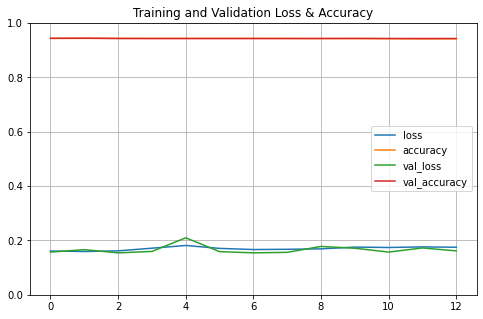

In [78]:
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.title('Training and Validation Loss & Accuracy')
    plt.show()

plot_learning_curves(history)

In [79]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("\nTest accuracy:", test_accuracy)
print("Test loss:", test_loss)

62/62 [==============================] - 0s 820us/step - loss: 0.1656 - accuracy: 0.9376

Test accuracy: 0.9376267790794373
Test loss: 0.16559016704559326


1220/1220 [==============================] - 1s 604us/step


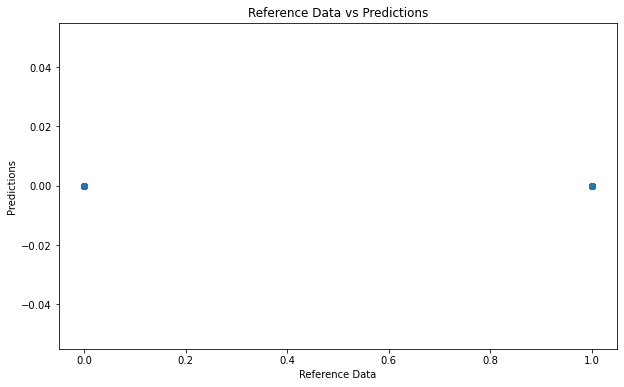

In [80]:
import numpy as np
import matplotlib.pyplot as plt

# 모델로부터 예측값을 얻습니다.
y_pred = model.predict(X_valid)

# y_pred가 one-hot encoded 되어있다면 argmax를 사용해 class index로 변환
y_pred_class = np.argmax(y_pred, axis=1)

plt.figure(figsize=(10, 6))
plt.scatter(y_valid, y_pred_class, alpha=0.5)
plt.xlabel('Reference Data')
plt.ylabel('Predictions')
plt.title('Reference Data vs Predictions')
plt.show()
